## DATA UNDERSTANDING

In [51]:
#Importing necessary libraries

import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import warnings
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET
warnings.filterwarnings('ignore')
import os

# Download improved NLP resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [52]:
#Creating a class to load and process cancer-related Q&A data from XML files 

class CancerQALoader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.questions = []
        self.answers = []
        self.root = None
        self.source = os.path.splitext(os.path.basename(filepath))[0] 

    def parse_xml(self):
        try:
            tree = ET.parse(self.filepath)
            self.root = tree.getroot()
        except ET.ParseError as e:
            print(f"Error parsing XML in {self.filepath}: {e}")
        except FileNotFoundError:
            print(f"File not found: {self.filepath}")

    def extract_qa_pairs(self):
        if self.root is None:
            return

        for qa_pair in self.root.findall('.//QAPair'):
            question = qa_pair.find('Question').text
            answer = qa_pair.find('Answer').text
            if question and answer:
                self.questions.append(question)
                self.answers.append(answer)

    def get_dataframe(self):
        return pd.DataFrame({
            'question': self.questions,
            'answer': self.answers,
            'source': [self.source] * len(self.questions)  # Add source to each row
        })

    def load_all_qa_from_folder(folder_path):
        all_dfs = []

        for filename in os.listdir(folder_path):
            if filename.endswith(".xml"):
                full_path = os.path.join(folder_path, filename)
                loader = CancerQALoader(full_path)
                loader.parse_xml()
                loader.extract_qa_pairs()
                df = loader.get_dataframe()
                all_dfs.append(df)

        return pd.concat(all_dfs, ignore_index=True)

In [53]:
#We used the class to load all Q&A pairs from XML files in a specified folder
folder = ('1_CancerGov_QA' ) 
cancer_df = CancerQALoader.load_all_qa_from_folder(folder)

In [54]:
#Displaying the number of files loaded into the cancer_df DataFrame
print(f"Reading {cancer_df['source'].nunique()} files")

Reading 116 files


In [55]:
#Displaying the first 20 rows of the DataFrame
cancer_df.head(20)

,question,answer,source
0,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points\n - Adult acute ...,0000001_1
1,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,...",0000001_1
2,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...,0000001_1
3,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...,0000001_1
4,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...,0000001_1
5,What are the stages of Adult Acute Lymphoblast...,Key Points\n - Once adult A...,0000001_1
6,What are the treatments for Adult Acute Lympho...,Key Points\n - There are di...,0000001_1
7,What is (are) Adult Acute Myeloid Leukemia ?,Key Points\n - Adult acute ...,0000001_2
8,Who is at risk for Adult Acute Myeloid Leukemi...,"Smoking, previous chemotherapy treatment, and ...",0000001_2
9,What are the symptoms of Adult Acute Myeloid L...,"Signs and symptoms of adult AML include fever,...",0000001_2


In [56]:
#Checking the shape of the DataFrame to see how many rows and columns it contains
cancer_df.shape

(729, 3)

In [57]:
#Checking the information about the DataFrame, including data types and non-null counts
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  729 non-null    object
 1   answer    729 non-null    object
 2   source    729 non-null    object
dtypes: object(3)
memory usage: 17.2+ KB


In [58]:
#Checking the number of missing values in each column of the DataFrame
cancer_df.isnull().sum()

question    0
answer      0
source      0
dtype: int64

In [59]:
#Checking the number of rows in the DataFrame to see how many Q&A pairs were loaded
len(cancer_df)

729

In [60]:
#Checking the data type of the DataFrame to confirm it is a pandas DataFrame
type(cancer_df)

pandas.core.frame.DataFrame

In [61]:
# Check how many duplicate questions exist
duplicate_questions = cancer_df[cancer_df.duplicated(subset='question', keep=False)]
print(f"Total duplicate questions: {duplicate_questions.shape[0]}")
duplicate_questions


Total duplicate questions: 78


,question,answer,source
22,What is (are) Chronic Myelogenous Leukemia ?,Key Points\n - Chronic myel...,0000001_4
29,What are the treatments for Chronic Myelogenou...,Key Points\n - There are di...,0000001_4
246,What is (are) Liver (Hepatocellular) Cancer ?,Key Points\n - Liver cancer...,0000007_4
247,Who is at risk for Liver (Hepatocellular) Canc...,Being infected with certain types of the hepat...,0000007_4
250,What is (are) Liver (Hepatocellular) Cancer ?,Key Points\n - Liver cancer...,0000007_5
...,...,...,...
678,Who is at risk for Prostate Cancer? ?,Different factors increase or decrease the ris...,0000036_3
695,What is (are) Colorectal Cancer ?,Key Points\n - Colorectal c...,0000037_3
697,Who is at risk for Colorectal Cancer? ?,Key Points\n - Avoiding ris...,0000037_3
699,What is (are) Colorectal Cancer ?,Key Points\n - Colorectal c...,0000037_4


## DATA CLEANING

In [62]:
#Removing duplicate questions from the DataFrame while keeping the first occurrence
cancer_df=cancer_df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)

In [63]:
#Checking the shape of the DataFrame after removing duplicates to see how many rows remain
cancer_df.shape

(683, 3)

### DATA PREPROCESSING
Standardize text preprocessing to ensure consistency across training, validation, and inference.
In this case we use medical-specific stopwords and define a function that that handles medical terms carefully and preserves context.

In [64]:
#Defining a function to clean and preprocess the text data in the DataFrame
# Medical-specific stopwords
MEDICAL_STOPWORDS = set(stopwords.words('english')) | {
    'patient', 'cancer', 'may', 'also', 'include', 'following', 
    'key', 'point', 'points', 'doctor', 'medical'
}

lemmatizer = WordNetLemmatizer()

# Enhanced medical cleaning function
def clean_text(text):
    """Improved medical text cleaning with boilerplate removal"""
    if not isinstance(text, str):
        return ""
    # 1. Remove all boilerplate patterns first
    text = re.sub(r'Key Points.*?-', '', text)
    text = re.sub(r'\\n', ' ', text)           # Replace newlines with spaces
    text = re.sub(r'\s+', ' ', text)           # Collapse multiple spaces
    
    # 2. Preserve medical terms while cleaning
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s-]', ' ', text.lower())  # Keep hyphens in terms like "post-operative" 
   
    
    # 3. Enhanced medical token handling
    tokens = word_tokenize(text)
    filtered_tokens = []
    for word in tokens:
        # Keep medical terms longer than 2 chars, except stopwords
        if (len(word) > 2) and (word not in MEDICAL_STOPWORDS):
            # Special handling for medical plurals (e.g., therapies -> therapy)
            lemma = lemmatizer.lemmatize(word, pos='n')
            if lemma.endswith('ies'):
                lemma = lemma[:-3] + 'y'  # therapies -> therapy
            elif lemma.endswith('es'):
                lemma = lemma[:-2]  # diseases -> disease
            filtered_tokens.append(lemma)
    
    return ' '.join(filtered_tokens)


In [65]:
#remove spaces and new lines
cancer_df['question'] = cancer_df['question'].str.strip().replace('\n', ' ')
cancer_df['answer'] = cancer_df['answer'].str.strip().replace('\n', ' ')


# Preprocess the questions and answers
cancer_df['question'] = cancer_df['question'].apply(clean_text)
cancer_df['answer'] = cancer_df['answer'].apply(clean_text)


In [66]:
#Checking the number of unique answers in the DataFrame
print(f"Number of unique answers: {cancer_df['answer'].nunique()}")
print(cancer_df['answer'].value_counts().head(5))


Number of unique answers: 655
answer
new type treatment tested clinical trial information clinical trial available nci website patient want think taking part clinical trial patient taking part clinical trial best treatment choice clinical trial part research process clinical trial done find new treatment safe effective better standard treatment many today standard treatment based earlier clinical trial patient take part clinical trial receive standard treatment among first receive new treatment patient take part clinical trial help improve way treated future even clinical trial lead effective new treatment often answer important question help move research forward patient enter clinical trial starting treatment clinical trial patient yet received treatment trial test treatment patient whose gotten better clinical trial test new way stop recurring coming back reduce side effect treatment clinical trial taking place many part country see treatment option section follows link current trea

In [67]:
#Displaying the first 10 rows of the DataFrame
cancer_df.head(10)

,question,answer,source
0,adult acute lymphoblastic leukemia,adult acute lymphoblastic leukemia type bone m...,0000001_1
1,symptom adult acute lymphoblastic leukemia,sign symptom adult fever feeling tired easy br...,0000001_1
2,diagnose adult acute lymphoblastic leukemia,test examine blood bone marrow used detect fin...,0000001_1
3,outlook adult acute lymphoblastic leukemia,certain factor affect prognosis chance recover...,0000001_1
4,risk adult acute lymphoblastic leukemia,previous chemotherapy exposure radiation incre...,0000001_1
5,stage adult acute lymphoblastic leukemia,adult diagnosed test done find spread central ...,0000001_1
6,treatment adult acute lymphoblastic leukemia,different type treatment patient adult treatme...,0000001_1
7,adult acute myeloid leukemia,adult acute myeloid leukemia aml type bone mar...,0000001_2
8,risk adult acute myeloid leukemia,smoking previous chemotherapy treatment exposu...,0000001_2
9,symptom adult acute myeloid leukemia,sign symptom adult aml fever feeling tired eas...,0000001_2


### HYBRID SEARCH SYSTEM

In [68]:
# Initialize models
tfidf_vectorizer = TfidfVectorizer(preprocessor=clean_text, stop_words=list(MEDICAL_STOPWORDS))
X_tfidf = tfidf_vectorizer.fit_transform(cancer_df['question'])

In [69]:
from sentence_transformers import SentenceTransformer

# Biomedical embedding model
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")
question_embeddings = model.encode(cancer_df['question'].tolist())

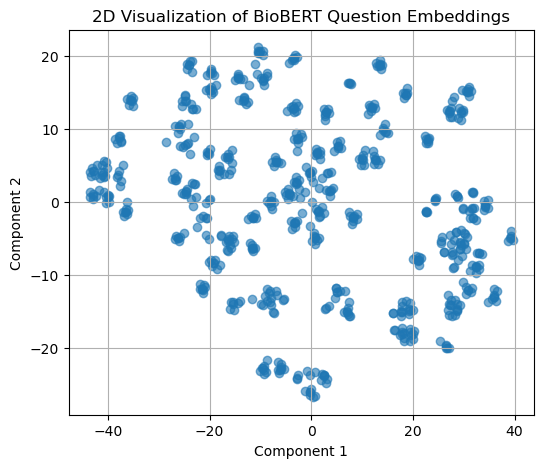

In [70]:
# 2D Visualization of Sentence Embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(question_embeddings)

plt.figure(figsize= (6,5))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
plt.title("2D Visualization of BioBERT Question Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

The scatter plot above displays a **2D t-SNE projection** of semantic embeddings generated by the BioBERT-based SentenceTransformer model for each cancer-related question in the dataset.
#### Key Observations:
- Several **tight clusters** can be seen, suggesting that BioBERT effectively groups similar medical questions like those about:
  - Symptoms and diagnosis
  - Cancer types
  - Treatment and medications
  - Survival and prognosis
- **Scattered points** may indicate outliers or uniquely phrased questions that do not fit well into larger semantic groups.

In [71]:
def hybrid_search(query, n=3, tfidf_weight=0.4, semantic_weight=0.6, threshold=0.5, disease_filter=None):
    """Enhanced hybrid search with disease filtering"""
    # Process query
    clean_query = clean_text(query)
    
    # TF-IDF similarity
    tfidf_vec = tfidf_vectorizer.transform([clean_query])
    tfidf_sim = cosine_similarity(tfidf_vec, X_tfidf).flatten()
    
    # Semantic similarity
    semantic_vec = model.encode([query])
    semantic_sim = cosine_similarity(semantic_vec, question_embeddings).flatten()
    
    # Combined score
    combined_sim = (tfidf_weight * tfidf_sim) + (semantic_weight * semantic_sim)
    
    # Get top results
    top_indices = np.argsort(combined_sim)[-n*3:][::-1]  # Get extra results for filtering
    top_matches = []
    for idx in top_indices:
        if combined_sim[idx] > threshold:
            match = {
                'question': cancer_df.iloc[idx]['question'],
                'answer': cancer_df.iloc[idx]['answer'],
                'similarity': float(combined_sim[idx]),
                'type': 'TF-IDF' if tfidf_sim[idx] > semantic_sim[idx] else 'Semantic'
            }
            
            # Apply disease filter if provided
            if not disease_filter or disease_filter.lower() in match['question'].lower():
                top_matches.append(match)
                
            if len(top_matches) >= n:  # Stop when we have enough filtered results
                break
    if not top_matches:
        return [{'answer': "I couldn't find a confident match. Please consult a doctor or rephrase your question.",
                'similarity': 0.0}]
    
    return top_matches[:n]  # Return exactly n results

## MODEL EVALUATION

In [72]:
# Enhanced validation set with disease-specific testing
validation_data = [
    {
        "query": "prostate cancer symptoms", 
        "expected": ["urinary", "urination", "flow", "frequent", "weak stream"],
        "disease": "prostate",
        "min_similarity": 0.5
    },
    {
        "query": "breast cancer treatment options", 
        "expected": ["surgery", "radiation", "chemotherapy", "mastectomy", "lumpectomy"],
        "disease": "breast",
        "min_similarity": 0.45
    },
    {
        "query": "leukemia causes", 
        "expected": ["genetic", "mutation", "radiation", "chemical", "chromosome"],
        "disease": "leukemia",
        "min_similarity": 0.4
    }
]
def evaluate_model(validation_set, n=3):
    total = len(validation_set)
    correct = 0
    detailed_results = []
    
    print("="*80)
    print("MEDICAL CHATBOT EVALUATION REPORT")
    print("="*80)
    
    for test in validation_set:
        # Perform hybrid search with disease filtering
        results = hybrid_search(
            test["query"],
            n=n,
            disease_filter=test.get("disease"),
            threshold=test.get("min_similarity", 0.4)
        )
        
        # Analyze matches
        found_keywords = set()
        best_match = None
        best_score = 0
        
        for res in results:
            answer = res['answer'].lower()
            for keyword in test["expected"]:
                if keyword.lower() in answer:
                    found_keywords.add(keyword)
            
            if res['similarity'] > best_score:
                best_match = res
                best_score = res['similarity']
        
        # Determine if test passed
        passed_test = len(found_keywords) > 0
        if passed_test:
            correct += 1
        
        # Store detailed results
        detailed_results.append({
            "query": test["query"],
            "passed": passed_test,
            "found_keywords": list(found_keywords),
            "best_match": best_match,
            "expected_keywords": test["expected"]
        })
        # Print test case results
        print(f"\nTEST CASE: {test['query']}")
        print(f"DISEASE FILTER: {test.get('disease', 'None')}")
        print(f"SIMILARITY THRESHOLD: {test.get('min_similarity', 0.4):.2f}")
        print("-"*60)
        print(f"EXPECTED KEYWORDS: {', '.join(test['expected'])}")
        print(f"FOUND KEYWORDS: {', '.join(found_keywords) if found_keywords else 'None'}")
        print(f"TOP MATCH SIMILARITY: {best_score:.2f}" if best_match else "No matches")
        if best_match:
            print(f"BEST MATCH QUESTION: {best_match['question']}")
            print(f"BEST MATCH ANSWER: {best_match['answer'][:150]}...")
        print(f"RESULT: {'PASS' if passed_test else 'FAIL'}")

       # Print summary
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    print(f"TOTAL TESTS: {total}")
    print(f"PASSED: {correct}")
    print(f"FAILED: {total - correct}")
    print(f"ACCURACY: {correct/total:.2%}")
    print("="*80)
    
    return detailed_results

# Run the evaluation
evaluation_results = evaluate_model(validation_data)

# Optional: Display failed cases in detail
print("\nFAILED CASE DETAILS:")
for result in evaluation_results:
    if not result["passed"]:
        print(f"\nQuery: {result['query']}")
        print(f"Expected Keywords: {result['expected_keywords']}")
        if result['best_match']:
            print(f"Closest Match: {result['best_match']['question']}")
            print(f"Match Answer: {result['best_match']['answer'][:200]}...")
        else:
            print("No matches found")    

MEDICAL CHATBOT EVALUATION REPORT

TEST CASE: prostate cancer symptoms
DISEASE FILTER: prostate
SIMILARITY THRESHOLD: 0.50
------------------------------------------------------------
EXPECTED KEYWORDS: urinary, urination, flow, frequent, weak stream
FOUND KEYWORDS: flow, frequent, urination, urinary
TOP MATCH SIMILARITY: 0.89
BEST MATCH QUESTION: symptom prostate
BEST MATCH ANSWER: sign prostate weak flow urine frequent urination sign symptom caused prostate condition check weak interrupted stop-and-go flow urine sudden urge urin...
RESULT: PASS

TEST CASE: breast cancer treatment options
DISEASE FILTER: breast
SIMILARITY THRESHOLD: 0.45
------------------------------------------------------------
EXPECTED KEYWORDS: surgery, radiation, chemotherapy, mastectomy, lumpectomy
FOUND KEYWORDS: radiation, lumpectomy, mastectomy, surgery, chemotherapy
TOP MATCH SIMILARITY: 0.84
BEST MATCH QUESTION: treatment breast
BEST MATCH ANSWER: different type treatment patient breast five type standard 

In [73]:
# Evaluating the model's accuracy on a validation set

correct = 0
total = len(validation_data)
k = 3  # Top-k

for item in validation_data:
    query = item["query"]
    expected_keywords = item["expected"]

    top_results = hybrid_search(query, n=k, threshold=0.0)

    found = any(
        any(keyword.lower() in result["answer"].lower() for keyword in expected_keywords)
        for result in top_results
    )

    if found:
        correct += 1

accuracy = correct / total
print(f"Top-{k} Accuracy: {accuracy:.2%}")

Top-3 Accuracy: 100.00%


In [74]:
# Function to get a response based on user input with a similarity threshold
from difflib import SequenceMatcher

def get_response(user_input, threshold=0.7):
    processed_input = clean_text(user_input)
    for index, row in cancer_df.iterrows():
        question = clean_text(row['question'])
        similarity = SequenceMatcher(None, processed_input, question).ratio()
        if similarity >= threshold:
            return row['answer']
    return "I'm sorry, I don't have information on that. Please consult a doctor."

In [75]:
for item in hybrid_search("Signs of throat cancer?"):
    print(item["answer"])


I couldn't find a confident match. Please consult a doctor or rephrase your question.


### USER INTERFACE

In [ ]:
import gradio as gr

def chatbot(query):
    results = hybrid_search(query)
    top_result = results[0]
    if top_result["question"] is None:
        return top_result["answer"]
    return f"*Question: {top_result['question']}\nAnswer: {top_result['answer']}\nSimilarity*: {top_result['similarity']:.2f}"

interface = gr.Interface(
    fn=chatbot,
    inputs=gr.Textbox(label="Enter your question about cancer"),
    outputs=gr.Textbox(label="Answer"),
    title="Cancer QA Chatbot",
    description="Ask questions about cancer symptoms, treatments, or risk factors."
)
interface.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\User\anaconda3\Lib\site-packages\gradio\queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\Lib\site-packages\gradio\blocks.py", line 2229, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\Lib\site-packages\gradio\blocks.py", line 1740, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\Lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
      